In [ ]:
# 📦 Install Required Packages
!pip install pandas networkx pyvis matplotlib biopython sentence-transformers tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 📚 Import Libraries
import pandas as pd
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
from Bio import Entrez
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

In [ ]:
# 📁 Upload the CSV File
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

Saving thyroid_cancer_relationships.csv to thyroid_cancer_relationships.csv


In [ ]:
# 🧠 Manual ID-to-Name Mapping
id_to_name = {
    'DOID:1781': 'Anaplastic Thyroid Cancer',
    '80142': 'BRAF gene',
    '1356': 'RET gene',
    '673': 'EGFR gene',
    '8031': 'ALK gene',
    '6256': 'TSC2 gene',
    '3440': 'IRS1 gene',
    '23583': 'MED12 gene',
    'UBERON:0001585': 'thyroid gland',
    'UBERON:0001044': 'head and neck region',
    'D014832': 'Neoplasm Metastasis',
    '7157': 'TP53 gene',
    '5291': 'PIK3CA gene',
    '50485': 'Sorafenib',
    '8622': 'Vemurafenib',
    '5468': 'Thyroglobulin',
    # Add more as needed
}

In [ ]:
# 🌐 Build the Graph
G = nx.MultiDiGraph()
for _, row in df.iterrows():
    src = row['source_id']
    tgt = row['target_id']
    relation = row['kind']
    src_type = row['source_type']
    tgt_type = row['target_type']
    evidence = row['sources']
    G.add_node(src, type=src_type)
    G.add_node(tgt, type=tgt_type)
    G.add_edge(src, tgt, kind=relation, sources=evidence)

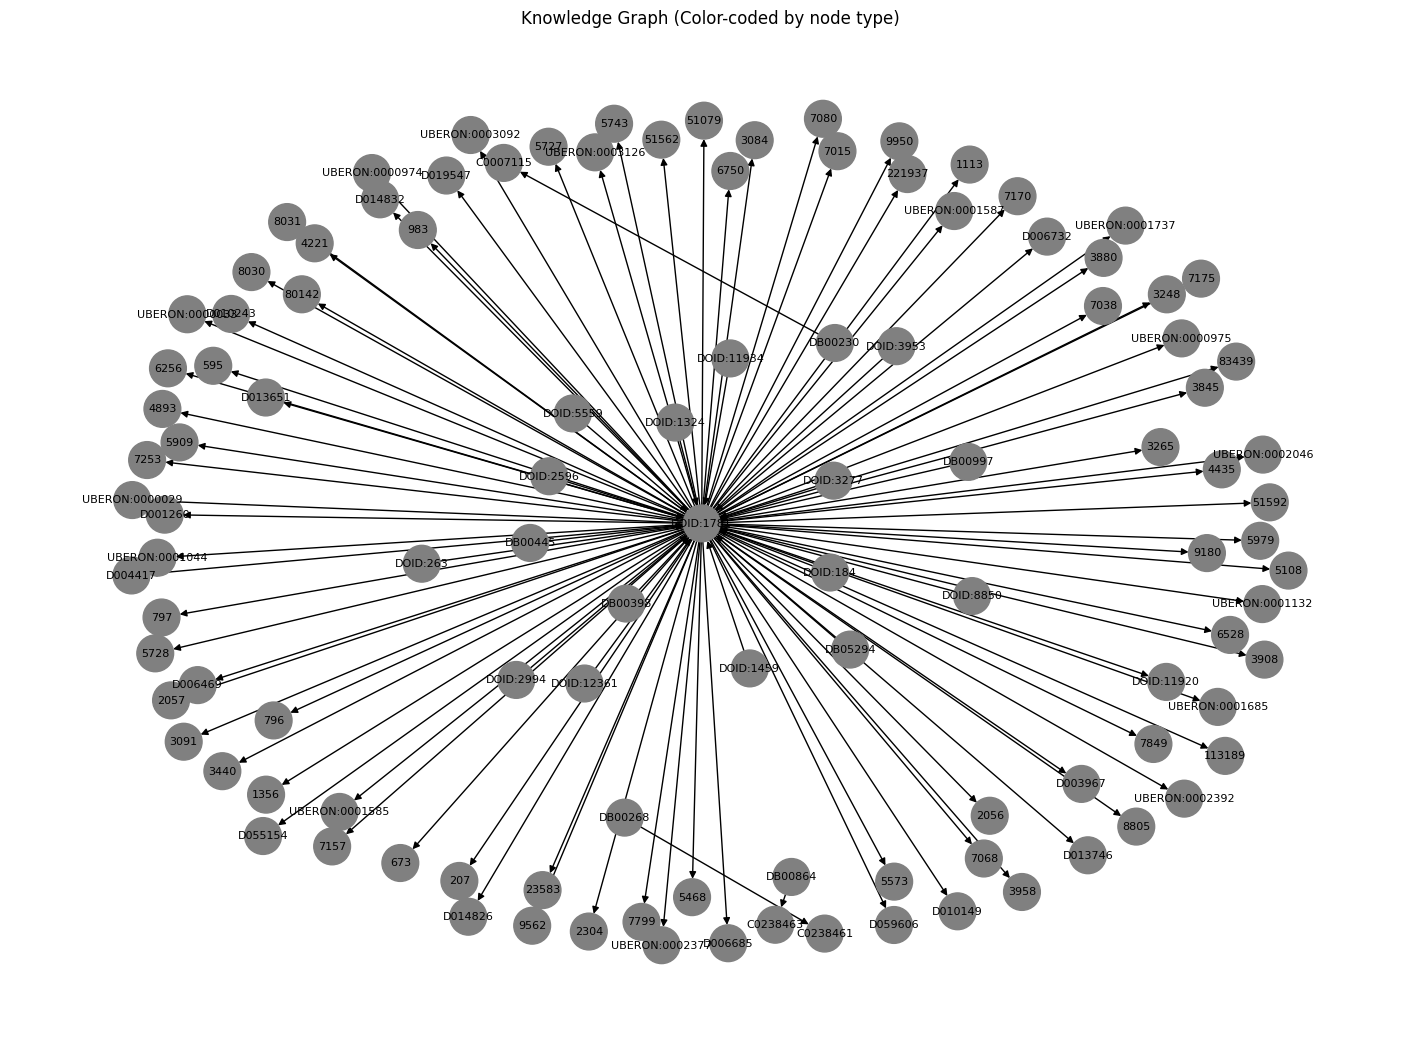

In [ ]:
# 🎨 Static Visualization
color_map = {'drug': 'skyblue', 'gene': 'lightgreen', 'disease': 'salmon'}
node_colors = [color_map.get(G.nodes[n]['type'], 'gray') for n in G.nodes()]
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=700, font_size=8)
plt.title("Knowledge Graph (Color-coded by node type)")
plt.show()

In [ ]:
# 📈 Centrality Metrics
deg_cent = nx.degree_centrality(G)
top_hubs = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("🔝 Top Hub Nodes:")
for node, score in top_hubs:
    print(f"{id_to_name.get(node, node)} ({G.nodes[node]['type']}): {score:.4f}")

🔝 Top Hub Nodes:
Anaplastic Thyroid Cancer (Disease): 0.9459
BRAF gene (Gene): 0.0090
ALK gene (Gene): 0.0090
DOID:184 (Disease): 0.0090
RET gene (Gene): 0.0090
EGFR gene (Gene): 0.0090
Neoplasm Metastasis (Symptom): 0.0090
thyroid gland (Anatomy): 0.0090
DB00230 (Compound): 0.0090
C0007115 (Side Effect): 0.0090


In [ ]:
# 🌐 Interactive Graph with Pyvis
nt = Network(height="700px", width="100%", notebook=True, directed=True)
nt.force_atlas_2based()
for node, data in G.nodes(data=True):
    color = color_map.get(data.get("type", "unknown"), "gray")
    label = id_to_name.get(node, node)
    nt.add_node(node, label=label, title=data.get("type", "N/A"), color=color)
for src, tgt, data in G.edges(data=True):
    nt.add_edge(src, tgt, label=data.get("kind", ""))
nt.show("interactive_graph.html")

interactive_graph.html


In [ ]:
# 🔍 Setup for PubMed + BioBERT Validation
Entrez.email = "nida.amir0083@gmail.com"
model = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')

In [ ]:
def search_pubmed(term, max_results=10):
    try:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=max_results)
        record = Entrez.read(handle)
        return record["IdList"]
    except:
        return []

In [ ]:
def fetch_abstracts(pubmed_ids):
    abstracts = []
    if not pubmed_ids:
        return abstracts
    handle = Entrez.efetch(db="pubmed", id=",".join(pubmed_ids), rettype="abstract", retmode="text")
    for line in handle:
        abstracts.append(line.strip())
    return abstracts

In [ ]:
def get_similarity_score(text1, text2):
    emb1 = model.encode(text1, convert_to_tensor=True)
    emb2 = model.encode(text2, convert_to_tensor=True)
    score = util.pytorch_cos_sim(emb1, emb2)
    return float(score[0][0])

In [ ]:
def validate_hypothesis(src, tgt, relation):
    src_name = id_to_name.get(src, src)
    tgt_name = id_to_name.get(tgt, tgt)
    query = f"{src_name} AND {tgt_name}"
    pubmed_ids = search_pubmed(query)
    abstracts = fetch_abstracts(pubmed_ids)
    if not abstracts:
        return 0.0
    hypothesis = f"{src_name} {relation} {tgt_name}"
    return max(get_similarity_score(hypothesis, abs_text) for abs_text in abstracts)

In [ ]:
# 🔬 Validate Sample Edges
validated = []
for src, tgt, data in tqdm(list(G.edges(data=True))[:10]):
    score = validate_hypothesis(src, tgt, data.get("kind", "related_to"))
    validated.append((src, tgt, data['kind'], score))
validated.sort(key=lambda x: -x[3])

# Calculate a single bio_score (e.g., the average or max score)
bio_score = 0.0
if validated:
    bio_score = sum(score for _, _, _, score in validated) / len(validated) # Using average score

print("🔬 Top Validated Relationships:")
for src, tgt, rel, score in validated:
    print(f"{id_to_name.get(src, src)} --{rel}--> {id_to_name.get(tgt, tgt)} | Score: {score:.4f}")

100%|██████████| 10/10 [01:50<00:00, 11.02s/it]

🔬 Top Validated Relationships:
Anaplastic Thyroid Cancer --associates--> RET gene | Score: 0.8660
Anaplastic Thyroid Cancer --associates--> EGFR gene | Score: 0.8342
Anaplastic Thyroid Cancer --localizes--> thyroid gland | Score: 0.8186
Anaplastic Thyroid Cancer --localizes--> head and neck region | Score: 0.7834
Anaplastic Thyroid Cancer --associates--> MED12 gene | Score: 0.7692
Anaplastic Thyroid Cancer --associates--> BRAF gene | Score: 0.7444
Anaplastic Thyroid Cancer --presents--> Neoplasm Metastasis | Score: 0.7366
Anaplastic Thyroid Cancer --associates--> ALK gene | Score: 0.7202
Anaplastic Thyroid Cancer --associates--> TSC2 gene | Score: 0.6924
Anaplastic Thyroid Cancer --associates--> IRS1 gene | Score: 0.6434


In [ ]:
# Convert MultiDiGraph to simple undirected Graph for link prediction
G_simple = nx.Graph()
for u, v in G.edges():
    G_simple.add_edge(u, v)

# Now use for resource_allocation_index
from networkx.algorithms.link_prediction import resource_allocation_index

atc_node = 'DOID:1781'
link_pred_score = 0.0  # Initialize link_pred_score
if atc_node in G_simple:
    preds = list(resource_allocation_index(G_simple))
    drug_candidates = []
    for u, v, score in preds:
        if atc_node in (u, v):
            candidate = v if u == atc_node else u
            if G.nodes.get(candidate, {}).get("type") == "drug":
                drug_candidates.append((candidate, score))

    print("\\n💊 Candidate Repurposing Drugs:")
    # Sort and get the top score for link_pred_score
    sorted_candidates = sorted(drug_candidates, key=lambda x: -x[1])
    if sorted_candidates:
        link_pred_score = sorted_candidates[0][1] # Assign the top score
        for drug, score in sorted_candidates[:5]:
            print(f"{id_to_name.get(drug, drug)}: score={score:.4f}")
    else:
        print("No drug candidates found.")
else:
    print("❌ ATC node not found")

\n💊 Candidate Repurposing Drugs:
No drug candidates found.


In [ ]:
df_results = pd.DataFrame(validated, columns=['Source', 'Target', 'Relation', 'BioBERT_Score'])
df_results.to_csv("validated_biokg_edges.csv", index=False)
